In [5]:
# Alif Firmansyah
# 1103204105
# UTS : Credit Score Classification 
# Dataset : Credit Score Classification, Model : Random Forest
# Dokumentasi/Referensi : https://www.kaggle.com/code/romanniki/guide-97-acc-clean-ftrs-ml-fr-xgb-fc-s

# 1. Memuat Library

In [6]:
import numpy as np
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Memuat Data

In [7]:
train = pd.read_csv("/kaggle/input/credit-score-classification/train.csv")
train.head()

/tmp/ipykernel_33/444851856.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/kaggle/input/credit-score-classification/train.csv")


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Terlihat banyak data yang kosong, mari kita bersihkan satu persatu.

# 3. Membersihkan Data

 **3.1 Menyesuaikan Format Data**

In [9]:
# Age / Loans / Delayed Payments
train['Age'] = train['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Loan'] = train['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

In [10]:
# Annual Income
train['Annual_Income'] = train['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
train['Annual_Income'] = train['Annual_Income'].astype(float)

In [11]:
# Credit Limit
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].replace('_', np.nan)
train['Changed_Credit_Limit'] = pd.to_numeric(train['Changed_Credit_Limit'], errors='coerce')
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].fillna(0)

In [12]:
# Outstanding Debt
# Convert data ke numeric
train['Outstanding_Debt'] = train['Outstanding_Debt'].astype(str)
train['Outstanding_Debt'] = train['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
train['Outstanding_Debt'] = pd.to_numeric(train['Outstanding_Debt'], errors='coerce')
train['Outstanding_Debt'] = train['Outstanding_Debt'].fillna(0)

In [13]:
# Monthly Investation
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].astype(str)
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].replace('', '0')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
train['Amount_invested_monthly'] = pd.to_numeric(train['Amount_invested_monthly'], errors='coerce')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].fillna(0)

In [14]:
# Monthly Balance
train['Monthly_Balance'] = train['Monthly_Balance'].astype(str)
train['Monthly_Balance'] = train['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
train['Monthly_Balance'] = pd.to_numeric(train['Monthly_Balance'], errors='coerce')
train['Monthly_Balance'] = train['Monthly_Balance'].fillna(0)

In [15]:
# Credit History Age
# Konversi datanya untuk konstruksi model lebih baik

def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0 
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0' 
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0  

train['Credit_History_Age_Months'] = train['Credit_History_Age'].apply(parse_years_and_months)

**3.2 Menghilangkan Duplikasi**

In [16]:
# Check for duplicate rows
duplicate_rows = train.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Check if there are any duplicates
if num_duplicates > 0:
    print("Duplikat ditemukan")
else:
    print("Tidak ada duplikat.")

Tidak ada duplikat.


**3.3 Data Scaling**

In [17]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,6.847573e+02,14.000000,25.000000,34.000000,42.000000,8.698000e+03
Annual_Income,100000.0,176415.701298,1.429618e+06,7005.930000,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,100000.0,10.761960,6.178993e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,100000.0,28.779410,2.181148e+02,0.000000,8.000000,13.000000,18.000000,4.397000e+03
Changed_Credit_Limit,100000.0,10.171791,6.880628e+00,-6.490000,4.970000,9.250000,14.660000,3.697000e+01


Terlihat banyak outlier, mari kita scaling

In [18]:
# Columns to scale
columns_to_scale = ['Num_Bank_Accounts', 'Interest_Rate', 'Annual_Income', 
                    'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 
                    'Total_EMI_per_month', 'Num_of_Loan', 'Num_Credit_Card']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data for the specified columns
train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,684.757313,14.000000,25.000000,34.000000,42.000000,8698.000000
Annual_Income,100000.0,0.007003,0.059097,0.000000,0.000515,0.001264,0.002719,1.000000
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,0.010056,0.065261,0.000000,0.002223,0.003891,0.004447,1.000000
Num_Credit_Card,100000.0,0.014993,0.086096,0.000000,0.002668,0.003336,0.004670,1.000000
Interest_Rate,100000.0,0.012330,0.080473,0.000000,0.001208,0.002070,0.003278,1.000000
Num_of_Loan,100000.0,0.007194,0.041303,0.000000,0.001337,0.002005,0.004011,1.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,100000.0,0.006545,0.049605,0.000000,0.001819,0.002957,0.004094,1.000000
Changed_Credit_Limit,100000.0,10.171791,6.880628,-6.490000,4.970000,9.250000,14.660000,36.970000


**3.4 Data Entry Plus**

3.4.1 Filtering

In [20]:
train = train[train['Payment_Behaviour'] != '!@9#%8']

In [21]:
# Drop baris berisi '_______' pada kolom 'Occupation'

train = train[train['Occupation'] != '_______']
print(train['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [22]:
# Drop baris dimana 'Credit_Mix' berisi '_'

train = train[train['Credit_Mix'] != '_']
print(train['Credit_Mix'].unique())

['Good' 'Standard' 'Bad']


3.4.2 Negative Value

In [23]:
selected_columns = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in selected_columns:
    train = train[train[column] >= 0]

3.4.3 Drop Kolom

In [24]:
# Daftar kolom
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_History_Age',
                   'Monthly_Inhand_Salary', 'Type_of_Loan']

# Drop kolom tersebut
train.drop(columns=columns_to_drop, inplace=True)

**3.5 Missing Values**

In [25]:
# Drop baris dengan missing value
train.dropna(inplace=True)

# Reset index
train.reset_index(drop=True, inplace=True)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43228 entries, 1 to 65709
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           43228 non-null  int64  
 1   Annual_Income                 43228 non-null  float64
 2   Num_Bank_Accounts             43228 non-null  float64
 3   Num_Credit_Card               43228 non-null  float64
 4   Interest_Rate                 43228 non-null  float64
 5   Num_of_Loan                   43228 non-null  float64
 6   Delay_from_due_date           43228 non-null  int64  
 7   Num_of_Delayed_Payment        43228 non-null  float64
 8   Changed_Credit_Limit          43228 non-null  float64
 9   Num_Credit_Inquiries          43228 non-null  float64
 10  Outstanding_Debt              43228 non-null  float64
 11  Credit_Utilization_Ratio      43228 non-null  float64
 12  Payment_of_Min_Amount         43228 non-null  object 
 13  Total_

In [26]:
total_missing_values = train.isnull().sum().sum()

if total_missing_values == 0:
    print("Tidak ada data kosong")
else:
    print("Total missing values:", total_missing_values)

Tidak ada data kosong


# 4. Feature Engineering

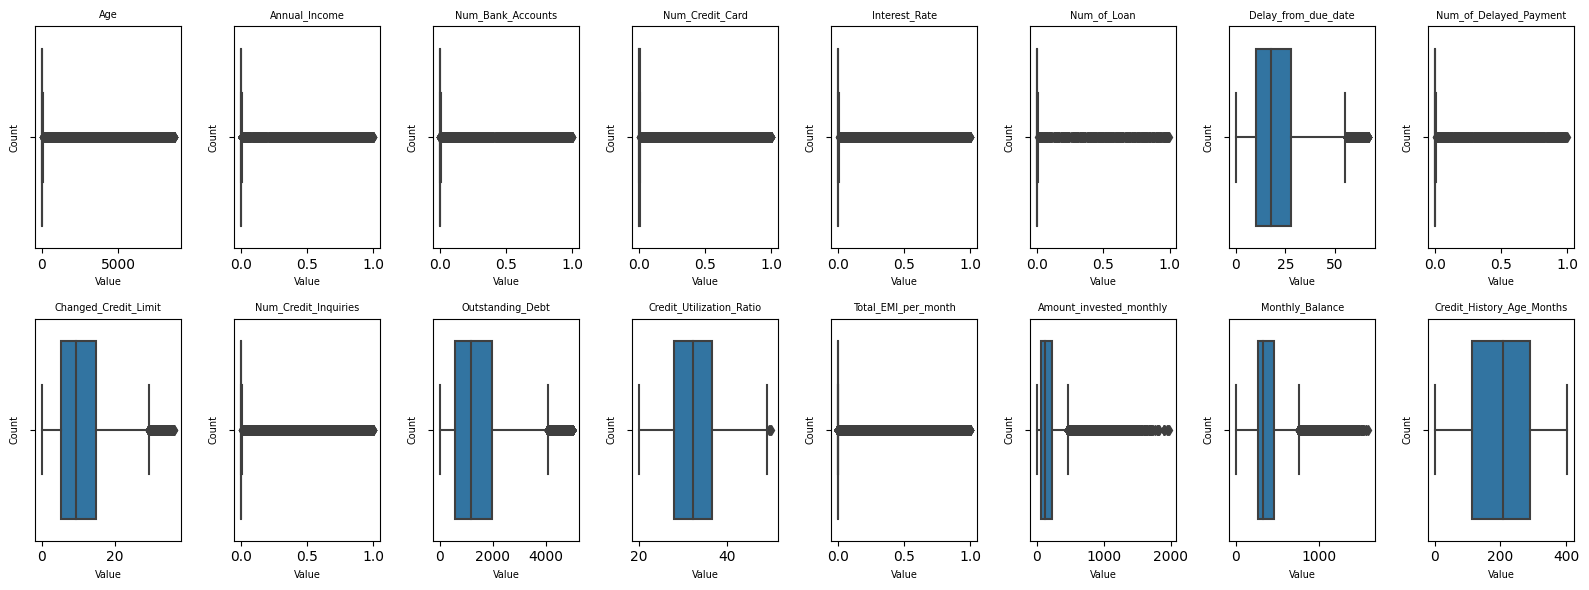

In [27]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=train[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)  
    axes[i].set_xlabel('Value', fontsize=7)  
    axes[i].set_ylabel('Count', fontsize=7)  

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**4.1 Scaling**

In [28]:
# Tune kolom
train = train[train['Age'] < 60]
train = train[train['Num_Credit_Card'] <= 10]
train = train[train['Interest_Rate'] <= 50]
train = train[train['Num_of_Loan'] <= 12]
train = train[train['Num_Bank_Accounts'] <= 10]
train = train[train['Delay_from_due_date'] <= 60]
train = train[train['Changed_Credit_Limit'] <= 30]
train = train[train['Num_Credit_Inquiries'] <= 12]
train = train[train['Total_EMI_per_month'] <= 200]
train = train[train['Outstanding_Debt'] <= 1500]

**4.2 Encoding**

4.2.1 Label Encoder

In [29]:
categories = ['Poor', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[categories])

train['Credit_Score_Encoded'] = encoder.fit_transform(train[['Credit_Score']])

In [30]:
# Encode Occupation

label_encoder = LabelEncoder()
train['Occupation_Encoded'] = label_encoder.fit_transform(train['Occupation'])

4.2.2 Ordinal Encoder

In [31]:
categories = ['Bad', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[categories])

train['Credit_Mix_Encoded'] = encoder.fit_transform(train[['Credit_Mix']])

In [32]:
categories_payment_behaviour = [
    'Low_spent_Small_value_payments', 
    'Low_spent_Medium_value_payments', 
    'Low_spent_Large_value_payments', 
    'High_spent_Small_value_payments', 
    'High_spent_Medium_value_payments', 
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

train['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(train[['Payment_Behaviour']])

Drop kolom yang tidak di encode

In [33]:
columns_to_drop = [ 'Payment_Behaviour', 'Credit_Mix', 'Occupation','Credit_Score']
train.drop(columns=columns_to_drop, inplace=True)

**4.3 Fitur Baru**
Membantu Meningkatkan akurasi dan mengurangi error

In [34]:
# Menghitung jumlah akun (Bank Accounts + Credit Cards)

train['Total_Num_Accounts'] = train['Num_Bank_Accounts'] + train['Num_Credit_Card']

# Menhgitung jumlah hutang per akun

train['Debt_Per_Account'] = train['Outstanding_Debt'] / train['Total_Num_Accounts']

# Menghitung perbandingan hutang dengan pemasukan

train['Debt_to_Income_Ratio'] = train['Outstanding_Debt'] / train['Annual_Income']

# Menghitung jumlah delayed payment per akun

train['Delayed_Payments_Per_Account'] = train['Num_of_Delayed_Payment'] / train['Total_Num_Accounts']

# Menghitung pengeluaran bulanan (EMI + Monthly Investments) 

train['Total_Monthly_Expenses'] = train['Total_EMI_per_month'] + train['Amount_invested_monthly']

**4.4 MI Score**

In [35]:
categorical_columns = train.select_dtypes(include=['object']).columns

data_encoded = train.copy()

encoder = OrdinalEncoder()
data_encoded[categorical_columns] = encoder.fit_transform(data_encoded[categorical_columns])

y = data_encoded['Credit_Score_Encoded']
X = data_encoded.drop(columns=['Credit_Score_Encoded'])

mi_scores = mutual_info_classif(X, y)

for i, score in enumerate(mi_scores):
    print(f"Feature '{X.columns[i]}': Mutual Information Score = {score}")

Feature 'Age': Mutual Information Score = 0.015619646254599218
Feature 'Annual_Income': Mutual Information Score = 0.4788109910449041
Feature 'Num_Bank_Accounts': Mutual Information Score = 0.05845675224703073
Feature 'Num_Credit_Card': Mutual Information Score = 0.06973427884145988
Feature 'Interest_Rate': Mutual Information Score = 0.09625340713348907
Feature 'Num_of_Loan': Mutual Information Score = 0.02162879442483545
Feature 'Delay_from_due_date': Mutual Information Score = 0.0728112513558763
Feature 'Num_of_Delayed_Payment': Mutual Information Score = 0.049262145432551474
Feature 'Changed_Credit_Limit': Mutual Information Score = 0.09530047224053195
Feature 'Num_Credit_Inquiries': Mutual Information Score = 0.034646912265098306
Feature 'Outstanding_Debt': Mutual Information Score = 0.47997281100454714
Feature 'Credit_Utilization_Ratio': Mutual Information Score = 0.0
Feature 'Payment_of_Min_Amount': Mutual Information Score = 0.07008009031622375
Feature 'Total_EMI_per_month': Mut

In [36]:
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)
sorted_columns = [x[0] for x in sorted_mi_scores]
sorted_scores = [x[1] for x in sorted_mi_scores]

colorscale = 'Viridis'  

fig = go.Figure(data=[go.Bar(x=sorted_columns, y=sorted_scores, marker=dict(color=sorted_scores, colorbar=dict(title='Mutual Information Score', len=0.5, y=0.2)))])

fig.update_layout(title='Mutual Information Scores for Each Feature',
                  xaxis_title='Features',
                  yaxis_title='Mutual Information Score')

fig.show()

# 5. Model Data

In [37]:
y = train['Credit_Score_Encoded']

X = train[['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Credit_History_Age_Months', 'Credit_Mix_Encoded', 'Total_Num_Accounts', 
       'Debt_Per_Account', 'Debt_to_Income_Ratio', 'Delayed_Payments_Per_Account']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

**5.1 Random Forest**

In [39]:
model = RandomForestRegressor(n_estimators=500, bootstrap=True, random_state=77)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=77)

**5.2 MSE**

In [40]:
# Hitung MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1674288451058621


**5.3 Accuracy**

In [41]:
rf_classifier = RandomForestClassifier(n_estimators=500, bootstrap=True)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

Accuracy on original test set: 0.8003701133472125

Classification report for original test set:
               precision    recall  f1-score   support

         0.0       0.76      0.65      0.70      1198
         1.0       0.83      0.86      0.84      5233
         2.0       0.75      0.74      0.75      2215

    accuracy                           0.80      8646
   macro avg       0.78      0.75      0.76      8646
weighted avg       0.80      0.80      0.80      8646



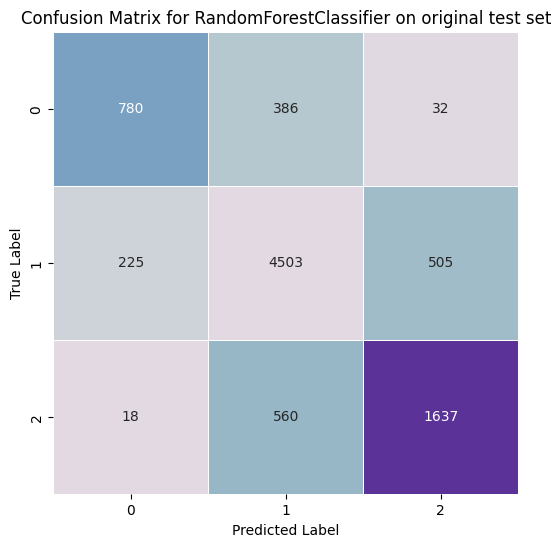

In [42]:
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on original test set:", accuracy)

matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for RandomForestClassifier on original test set')

print('\nClassification report for original test set:\n', classification_report(y_test, y_pred))